# Independence Tests Power over Increasing Dimension

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

from power import power
from hyppo.independence import CCA, MGC, RV, Dcorr, Hsic, HHG
from hyppo.sims import *

sys.path.append(os.path.realpath('..'))

In [2]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:], n_colors=9)

In [3]:
POWER_REPS = 5

In [4]:
SIMULATIONS = [
    "linear",
    "exponential",
    "cubic",
    "joint_normal",
    "step",
    "quadratic",
    "w_shaped",
    "spiral",
    "uncorrelated_bernoulli",
    "logarithmic",
    "fourth_root",
    "sin_four_pi",
    "sin_sixteen_pi",
    "square",
    "two_parabolas",
    "circle",
    "ellipse",
    "diamond",
    "multiplicative_noise",
    "multimodal_independence",
]

TESTS = [
#     MGCRF,
#     CCA,
#     MGC,
#     RV,
    Dcorr,
    Hsic,
#     HHG,
]

In [5]:
def find_dim(sim):
    if sim not in SIMULATIONS:
        raise ValueError("Invalid simulation")
        
    if sim in ["joint_normal", "sin_four_pi", "sin_sixteen_pi", "multiplicative_noise"]:
        dim = 10
    elif sim in ["multimodal_independence", "uncorrelated_bernoulli", "logarithmic"]:
        dim = 100
    elif sim in ["linear", "exponential", "cubic"]:
        dim = 1000
    elif sim in ["square", "diamond"]:
        dim = 40
    else:
        dim = 20
        
    return dim

def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

In [6]:
def estimate_power(sim, test):
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power(test, sim, p=dim, noise=False) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    np.savetxt('../fast/vs_dimension/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

def fast_estimate_power(sim, test):
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power(test, sim, p=dim, noise=False, auto=True) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    np.savetxt('../fast/vs_dimension/{}_Fast_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [7]:
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
# )

In [8]:
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(fast_estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
# )

In [13]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Multivariate Independence Testing (Increasing Dimension)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = SIMULATIONS[count]
            
            for test in TESTS:
                power = np.genfromtxt('../fast/vs_dimension/{}_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
                hsic_power = np.genfromtxt('../fast/vs_dimension/{}_Hsic.csv'.format(sim),
                                      delimiter=',')
                dim_range = find_dim_range(find_dim(sim))
                
                colors = {
                    "MGC" : "#e41a1c",
                    "Dcorr" : "#377eb8",
                    "Hsic" : "#4daf4a",
                }
                test_name = test.__name__
                if test_name in ["Dcorr", "Hsic"]:
                    fast_power = np.genfromtxt('../fast/vs_dimension/{}_Fast_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
                
                if test_name == "MGC":
                    col.plot(dim_range, (power - hsic_power), color=colors[test_name], label=test_name, lw=2)
                elif test_name in ["Dcorr", "Hsic"]:
                    col.plot(dim_range, (power - hsic_power), color=colors[test_name], label=test_name, lw=4)
                    col.plot(dim_range, (fast_power - hsic_power), color=colors[test_name], label="Fast " + test_name, lw=4, linestyle='dashed')
                else:
                    col.plot(dim_range, (power - hsic_power), label=test_name, lw=2)
                col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.07, 'Dimensions', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to Hsic', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../fast/figs/indep_power_dimension.pdf', transparent=True, bbox_inches='tight')

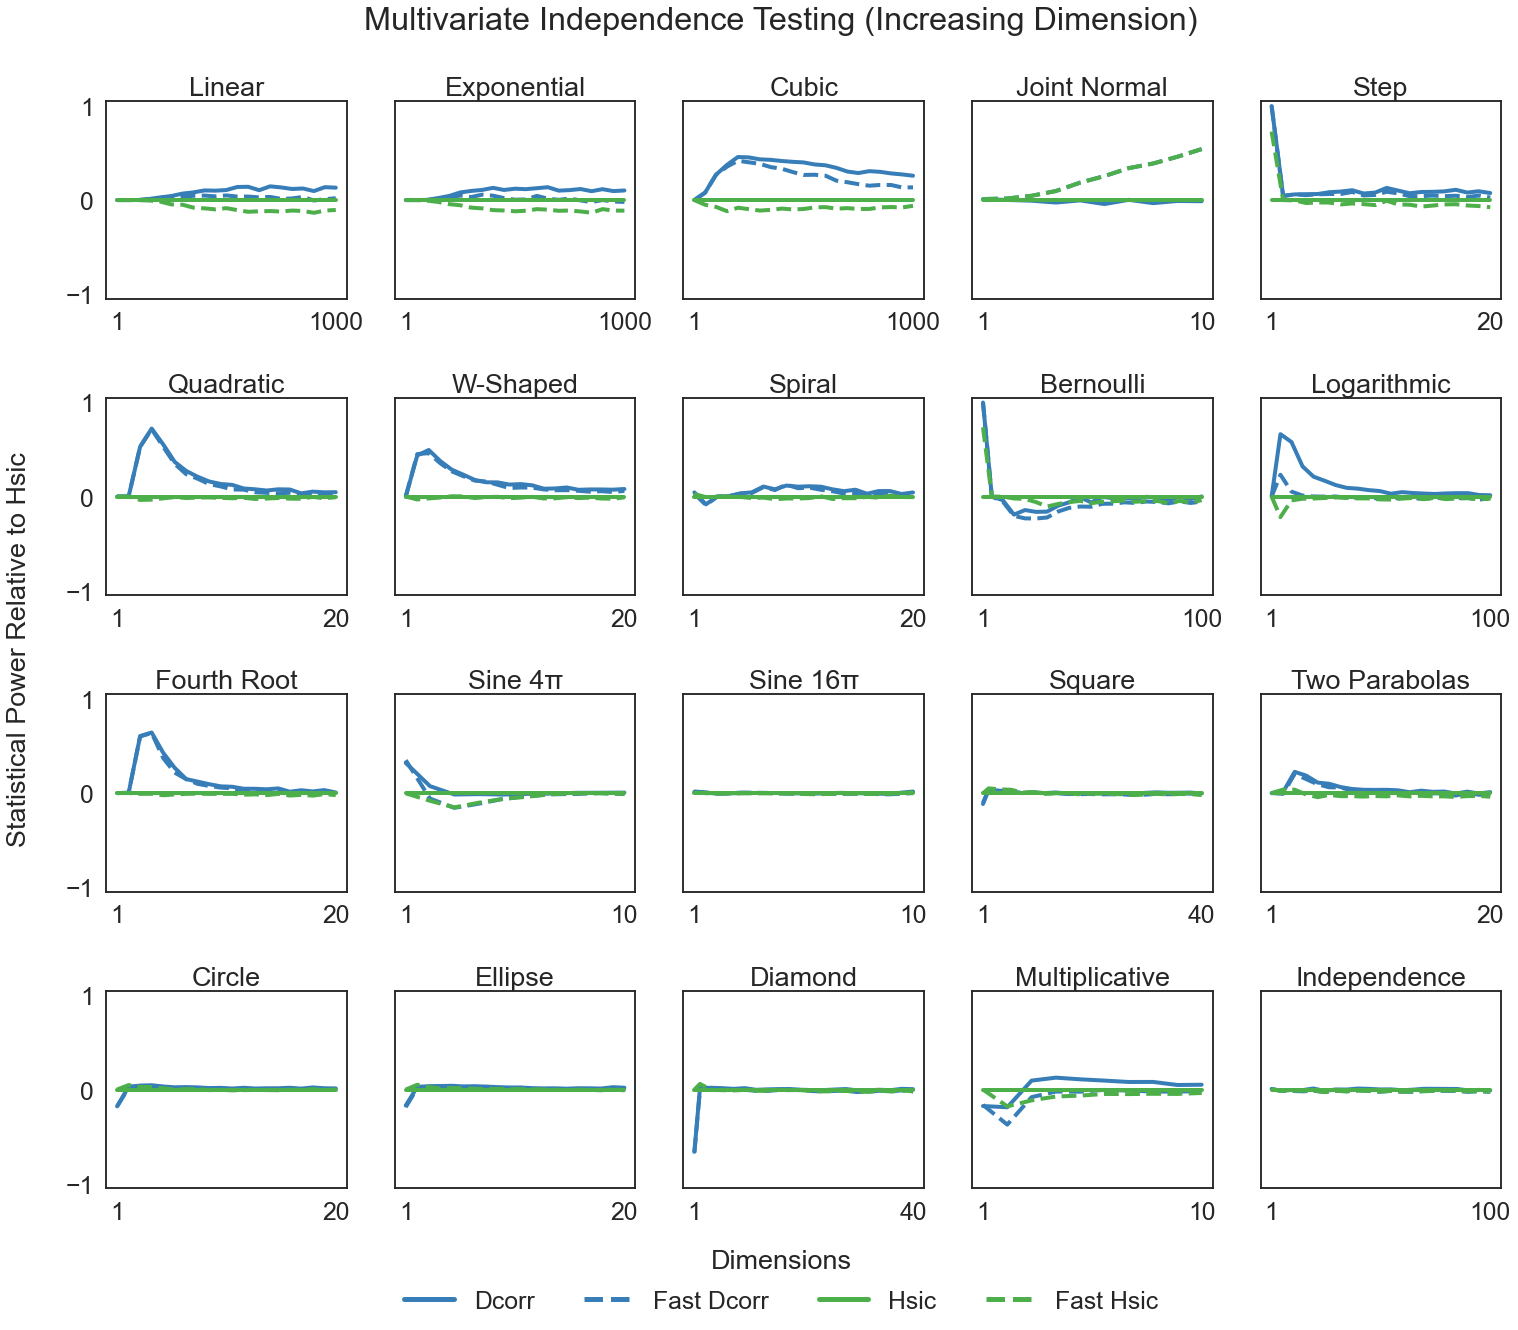

In [14]:
plot_power()